## 1. **Configure the Notebook:** 

In [1]:
# Import necessary libraries
import numpy as np
from xarray_healpy import HealpyGridInfo, HealpyRegridder
from pangeo_fish.grid import center_longitude
import xarray as xr
import pandas as pd
import xdggs
from pangeo_fish.hmm.estimator import EagerEstimator
from pangeo_fish.hmm.optimize import EagerBoundsSearch
from pangeo_fish.utils import temporal_resolution
from pangeo_fish.hmm.prediction import Gaussian1DHealpix,Gaussian2DCartesian
from tlz.functoolz import curry
from pint_xarray import unit_registry as ureg

# earth_radius defines the radius of the Earth used for distance calculations.
earth_radius = ureg.Quantity(6371, "km")
# maximum_speed sets the maximum allowable speed for the tagged fish.
maximum_speed = ureg.Quantity(60, "km / day")

# It will factor the allowed maximum displacement of the fish.
adjustment_factor = 5
# truncate sets the truncating factor for computed maximum allowed sigma for convolution process.
truncate = 4
tolerance = 1e-6
# Defines default chunk size for optimisation.
chunk_time = 24
default_chunk = {"time": chunk_time, "lat": -1, "lon": -1}
default_chunk_xy = {"time": chunk_time, "x": -1, "y": -1}
default_chunk_cells = {"time": chunk_time, "cells": -1}

/home/ecap/micromamba/envs/pangeo-fish/lib/python3.11/site-packages/movingpandas/__init__.py:37: UserWarning: Missing optional dependencies. To use the trajectory smoother classes please install Stone Soup (see https://stonesoup.readthedocs.io/en/latest/#installation).
  warnings.warn(e.msg, UserWarning)


In [2]:
import xarray as xr
emission = xr.open_dataset('../A19124/combined.zarr',
                           engine="zarr",
                           chunks={},
                           inline_array=True,
                           storage_options=None,
                        )
emission

<xarray.Dataset> Size: 409MB
Dimensions:     (y: 294, x: 659, time: 258)
Coordinates:
    cell_ids    (y, x) int64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    latitude    (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    longitude   (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: y, x
Data variables:
    final       (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    initial     (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    mask        (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    pdf         (time, x, y) float64 400MB dask.array<chunksize=(24, 659, 294), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

In [3]:
def sigma_to_radian(sigma, earth_radius_km=6371):
    """
    Convert sigma (arc length) to radians.
    
    Parameters:
    - sigma: float, the arc length in the same unit as earth_radius_km.
    - earth_radius_km: float, the Earth's radius in kilometers (default: 6371 km).
    
    Returns:
    - float: sigma in radians.
    """
    return np.sqrt(4*np.pi/(12*4096**2))*sigma


# Apply the function to sigma = 1.06
sigma = 1.06292
sigma_radian = sigma_to_radian(sigma)

print(f"Sigma in radians: {sigma_radian}")
earth_radius_ = xr.DataArray(earth_radius, dims=None)

timedelta = temporal_resolution(emission["time"]).pint.quantify().pint.to("h")
grid_resolution = earth_radius_ * emission["resolution"].pint.quantify()

maximum_speed_ = xr.DataArray(maximum_speed, dims=None).pint.to("km / h")
max_grid_displacement = maximum_speed_ * timedelta * adjustment_factor / grid_resolution
max_sigma = max_grid_displacement.pint.to("dimensionless").pint.magnitude / truncate

max_grid_displacement_radian = maximum_speed_ * timedelta * adjustment_factor / earth_radius_
max_sigma_radian = max_grid_displacement_radian.pint.to("dimensionless").pint.magnitude / truncate

# Applying max sigma over the emission matrices
emission.attrs["max_sigma"] = max_sigma_radian.item()
print(max_sigma.item())

print(max_sigma_radian)
emission

Sigma in radians: 0.00026555527939709026
1.963306279189256
0.0004905038455501491


/home/ecap/pangeo-fish/pangeo_fish/utils.py:122: FutureWarning: Hour.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  timedelta = to_offset(freq).delta.to_numpy()


<xarray.Dataset> Size: 409MB
Dimensions:     (y: 294, x: 659, time: 258)
Coordinates:
    cell_ids    (y, x) int64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    latitude    (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    longitude   (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: y, x
Data variables:
    final       (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    initial     (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    mask        (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    pdf         (time, x, y) float64 400MB dask.array<chunksize=(24, 659, 294), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0
    max_sigma:  0.0004905038455501491

In [4]:
print(np.sqrt(4*np.pi/(12*4096**2)) * 1.06292)

0.00026555527939709026


In [5]:
emission = emission.stack(cells=("y", "x"))
emission = emission.drop_vars(['x','y'])
# Set required attributes cleanly
emission["cell_ids"].attrs["grid_name"] = "healpix"
#emission_1D["cell_ids"].attrs["nest"] = True
# Récupérer les attributs existants de cell_ids
attrs_to_keep = ["level", "grid_name"]
# should also have nest
emission["cell_ids"].attrs = {key: value for key, value in emission["cell_ids"].
                              attrs.items() if key in attrs_to_keep}
emission

/tmp/ipykernel_56278/299093097.py:2: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'cells'} to avoid an error in the future.
  emission = emission.drop_vars(['x','y'])


<xarray.Dataset> Size: 409MB
Dimensions:     (cells: 193746, time: 258)
Coordinates:
    cell_ids    (cells) int64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    latitude    (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    longitude   (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    initial     (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    mask        (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    pdf         (time, cells) float64 400MB dask.array<chunksize=(24, 193746), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0
    max_sigma:  0.0004905038455501491

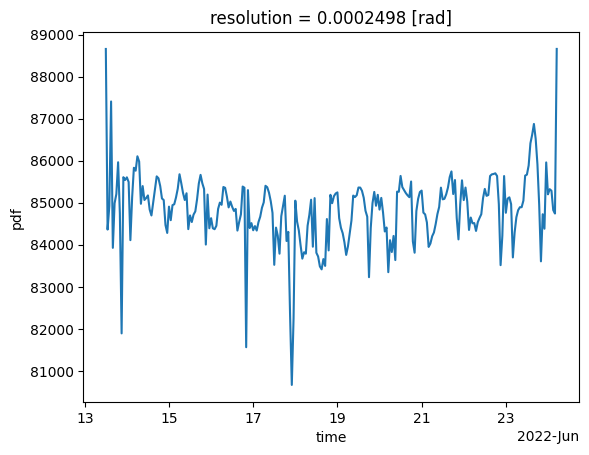

In [6]:

emission['pdf'].count(dim='cells').plot()

In [7]:
emission_full_one = emission.copy()  # Crée une copie pour éviter de modifier directement les données
emission_full_one['pdf'] = xr.ones_like(emission_full_one['pdf'])

In [8]:
#emission_regridded_plus = emission_regridded_plus.compute()  # WHAT DOES IT CHANGE?
emission_1D = emission_full_one.assign_coords({'cell_ids':lambda ds:ds['cell_ids'].compute()}).sortby('cell_ids').pipe(xdggs.decode)
predictor_factory = curry(
    Gaussian1DHealpix,
    cell_ids=emission_1D["cell_ids"].data,
    grid_info=emission_1D.dggs.grid_info,
    truncate=4.0,
    weights_threshold=1e-8,
    pad_kwargs={"mode": "constant", "constant_value": 0},
    optimize_convolution=True,
)
emission_1D

<xarray.Dataset> Size: 409MB
Dimensions:     (cells: 193746, time: 258)
Coordinates:
  * cell_ids    (cells) int64 2MB 55996335 55996346 ... 58020672 58020674
    latitude    (cells) float64 2MB 42.45 42.46 42.47 ... 54.06 54.06 54.08
    longitude   (cells) float64 2MB -7.398 -7.378 -7.357 ... -1.149 -1.149
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    initial     (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    mask        (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    pdf         (time, cells) float64 400MB dask.array<chunksize=(24, 193746), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0
    max_sigma:  0.0004905038455501491

In [9]:
##############################
# MANUELLEMENT AJOUT DU SIGMA
#############################
optimized = EagerEstimator(
            sigma=0.00026555527939709026,
            predictor_factory=predictor_factory)

optimized

EagerEstimator(predictor_factory=<class 'pangeo_fish.hmm.prediction.Gaussian1DHealpix'>, sigma=0.00026555527939709026, predictor=None)

In [10]:
emission_1D = emission_1D.compute()

In [73]:
emission_1D.initial.where(emission_1D.initial != 0, drop=True).dggs.explore()



Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [69]:
import healpy as hp
# 
nside = int(emission_1D.attrs["nside"])  # nside 4096
npix = hp.nside2npix(nside)  # Nombre total  pixels HEALPix

full_map = np.zeros(npix)

cell_ids = emission_1D.cell_ids.data  # indices HEALPix des cells
values = emission_1D.initial.data  
full_map[cell_ids] = values 

# 3.  healpy
smoothed_map = hp.sphtfunc.smoothing(full_map, fwhm=0.00026555527939709026,nest=True)


smoothed_values = smoothed_map[cell_ids] 


In [70]:
import xarray as xr

# Create an xarray Dataset for the extracted smoothed values
extracted_dataset = xr.Dataset(
    {
        "smoothed": xr.DataArray(
            data=smoothed_map[emission_1D.cell_ids.values],  # Extract the relevant smoothed values
            dims=["cells"],
            coords={
                "cell_ids": emission_1D.cell_ids,
                "latitude": emission_1D.latitude,
                "longitude": emission_1D.longitude,
            },
        )
    },
    attrs=emission_1D.attrs,  # Copy any attributes from the original dataset
)

# Extract the 'smoothed' DataArray from the extracted dataset
smoothed_data_array = extracted_dataset["smoothed"]

# Now visualize the smoothed data using dggs.explore on the DataArray
smoothed_data_array.pipe(xdggs.decode).dggs.explore(alpha=0.8)

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [15]:
states_1D = optimized.predict_proba(emission_1D)
states_1D = states_1D.to_dataset().chunk(default_chunk_cells).persist()
states_1D

<xarray.Dataset> Size: 405MB
Dimensions:     (cells: 193746, time: 258)
Coordinates:
  * cell_ids    (cells) int64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    latitude    (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    longitude   (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    states      (time, cells) float64 400MB dask.array<chunksize=(24, 193746), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)

In [75]:
states_1D.pipe(xdggs.decode).isel(time=5).compute().states.dggs.explore(alpha=0.8)

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [17]:
states_1D_from_2D = xr.open_dataset('states_from_emission_2D_emissionfullone.zarr',
                           engine="zarr",
                           chunks={},
                           inline_array=True,
                           storage_options=None,
                        )
states_1D_from_2D


<xarray.Dataset> Size: 408MB
Dimensions:     (cells: 193746, time: 258)
Coordinates:
    cell_ids    (cells) int64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    latitude    (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    longitude   (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
    x           (cells) int64 2MB dask.array<chunksize=(48437,), meta=np.ndarray>
    y           (cells) int64 2MB dask.array<chunksize=(48437,), meta=np.ndarray>
Dimensions without coordinates: cells
Data variables:
    states      (time, cells) float64 400MB dask.array<chunksize=(24, 193746), meta=np.ndarray>

In [18]:
states_1D_from_2D.pipe(xdggs.decode).isel(time=0).compute().states.dggs.explore(alpha=0.8)

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

15 15
64 148
148 412
264 804
412 1280
592 1853
804 2536
1028 3345
1280 4282
1556 5340
1853 6503
2177 7773
2535 9163
2926 10660
3344 12257
3795 13965
4281 15747
4799 17641


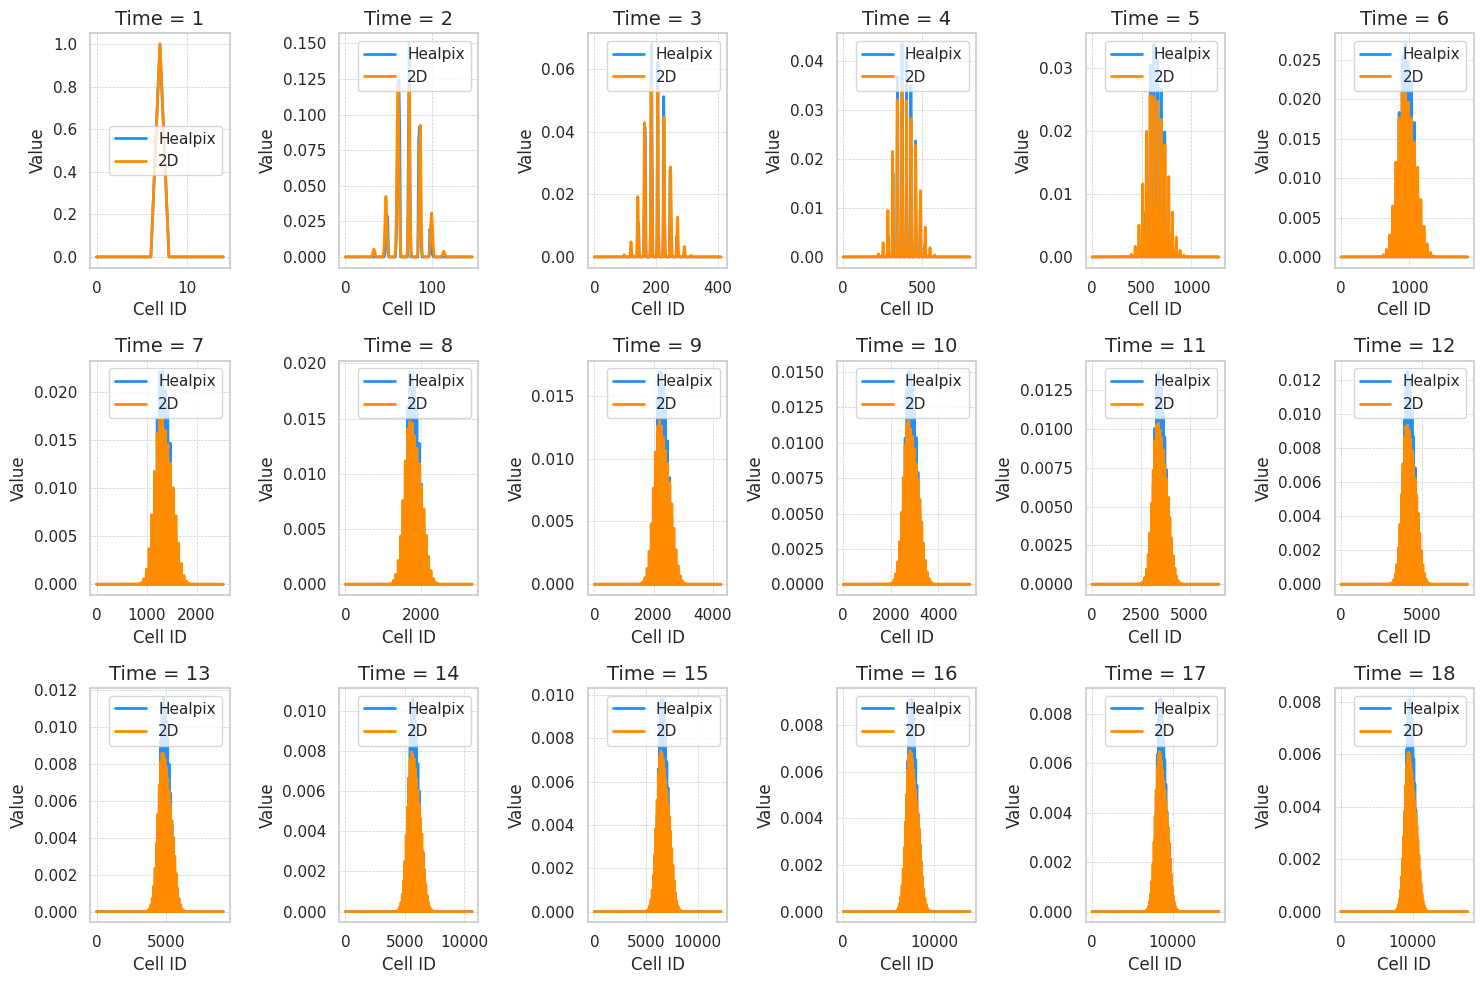

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns  # Pour une meilleure palette de couleurs

# Définir une palette de couleurs plus douce
sns.set(style="whitegrid", palette="muted")

test2 = states_1D_from_2D #2D
test = states_1D #healpix
im = np.zeros([12*4096**2])

fig, axes = plt.subplots(3, 6, figsize=(15, 10))  # Pour un meilleur arrangement des sous-graphes
axes = axes.flatten()

for k in range(18):
    idx1 = test.states.isel(time=k).dropna('cells').cell_ids.compute().data
    data1 = test.states.isel(time=k).dropna('cells').compute().data
    im[idx1] = data1
    idx2 = test2.states.isel(time=k).dropna('cells').cell_ids.compute().data
    data2 = test2.states.isel(time=k).dropna('cells').compute().data
    print(len(idx1), len(idx2))
    data1 = im[idx2]

    im[idx1] = 0.0
    
    # Tracer les données avec plus de détails
    axes[k].plot(data1, color='dodgerblue', lw=2, label="Healpix")  # Couleur plus douce
    axes[k].plot(data2, color='darkorange', lw=2, label="2D")  # Couleur différente pour la comparaison
    axes[k].set_title(f"Time = {k+1}", fontsize=14)  # Ajouter un titre pour chaque subplot
    axes[k].set_xlabel("Cell ID", fontsize=12)  # Ajouter des labels d'axe
    axes[k].set_ylabel("Value", fontsize=12)
    axes[k].legend()
    axes[k].grid(True, which='both', linestyle='--', linewidth=0.5)  # Ajouter une grille légère

# Ajuster l'espacement pour que les subplots ne se chevauchent pas
plt.tight_layout()
plt.savefig('convol_comp_emission_all1.png')
plt.show()


## 2D surface plus grande --> valeur moins importante .
## 

In [20]:
import numpy as np
import hvplot.pandas  # Extension pour hvplot
import holoviews as hv
import panel as pn

hv.extension('bokeh')  # Utiliser la bibliothèque Bokeh pour les rendus interactifs
pn.extension()

# Préparer les données pour un affichage interactif
test2 = states_1D_from_2D  # 2D
test = states_1D  # healpix
im = np.zeros([12 * 4096**2])

def get_data_for_time(k):
    """Récupérer les données pour un pas de temps spécifique."""
    idx1 = test.states.isel(time=k).dropna('cells').cell_ids.compute().data
    data1 = test.states.isel(time=k).dropna('cells').compute().data
    im[idx1] = data1
    
    idx2 = test2.states.isel(time=k).dropna('cells').cell_ids.compute().data
    data2 = test2.states.isel(time=k).dropna('cells').compute().data
    data1 = im[idx2]
    im[idx1] = 0.0
    
    return data1, data2, idx2

def plot_data(k):
    """Tracer les données pour un pas de temps spécifique avec des lignes ordonnées."""
    # Récupérer les données alignées
    data1, data2, idx2 = get_data_for_time(k)

    # Créer un DataFrame avec les indices et les valeurs
    df1 = pd.DataFrame({"Cell ID": idx2, "Value": data1, "Type": "Healpix"})
    df2 = pd.DataFrame({"Cell ID": idx2, "Value": data2, "Type": "2D"})

    # Trier par "Cell ID" pour garantir un tracé correct
    df1 = df1.sort_values("Cell ID")
    df2 = df2.sort_values("Cell ID")

    # Combiner les deux DataFrames pour faciliter le tracé
    df = pd.concat([df1, df2])

    # Tracer les lignes sans liaison incorrecte entre points
    plot = df.hvplot(
        kind="line",  # ou "scatter" si vous voulez des points séparés
        x="Cell ID",
        y="Value",
        by="Type",  # Une série différente pour chaque type
        line_width=2,
        title=f"Time = {k+1}",
        xlabel="Cell ID",
        ylabel="Value",
        grid=True,
        color=["dodgerblue", "darkorange"],
        legend="top",
    )
    return plot

# Créer un widget curseur pour naviguer dans le temps
slider = pn.widgets.IntSlider(name='Time Step', start=0, end=257, step=1, value=0)

# Associer le curseur au graphique
interactive_plot = pn.bind(plot_data, k=slider)

# Organiser l'interface utilisateur avec Panel
dashboard = pn.Column(
    "# Healpix VS 2D convolution",
    slider,
    interactive_plot
)

# Afficher l'interface utilisateur
dashboard.servable()


Column
    [0] Markdown(str)
    [1] IntSlider(end=257, name='Time Step')
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [21]:
emission_1D

<xarray.Dataset> Size: 409MB
Dimensions:     (cells: 193746, time: 258)
Coordinates:
  * cell_ids    (cells) int64 2MB 55996335 55996346 ... 58020672 58020674
    latitude    (cells) float64 2MB 42.45 42.46 42.47 ... 54.06 54.06 54.08
    longitude   (cells) float64 2MB -7.398 -7.378 -7.357 ... -1.149 -1.149
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    initial     (cells) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mask        (cells) float64 2MB nan nan nan nan nan ... nan nan nan nan nan
    pdf         (time, cells) float64 400MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0
    max_sigma:  0.0004905038455501491

In [22]:
emission_2D = xr.open_dataset('../A19124/combined.zarr',
                           engine="zarr",
                           chunks={},
                           inline_array=True,
                           storage_options=None,
                        )

emission_full_one = emission_2D.copy()
emission_full_one['pdf'] = xr.ones_like(emission_full_one['pdf'])
emission_2D = emission_full_one.compute()
emission_2D

<xarray.Dataset> Size: 409MB
Dimensions:     (y: 294, x: 659, time: 258)
Coordinates:
    cell_ids    (y, x) int64 2MB 55996335 56018181 ... 58020672 58020674
    latitude    (y, x) float64 2MB 42.45 42.46 42.47 42.49 ... 54.05 54.06 54.08
    longitude   (y, x) float64 2MB -7.398 -7.4 -7.402 ... -1.148 -1.149 -1.149
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: y, x
Data variables:
    final       (y, x) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    initial     (y, x) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mask        (y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan nan
    pdf         (time, x, y) float64 400MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Assume predictor_factory and optimized.sigma values are defined
predictor1 = predictor_factory(sigma=optimized.sigma)  # Predictor for the first matrix

predictor2 = curry(
    Gaussian2DCartesian,
    truncate=4.0
)  # Predictor for the second matrix
predictor3 = predictor2(sigma=1.06292)
print(predictor3)
# Initial tates for the matrices
alpha1 = emission_1D.initial.data  # Initial state for the first matrix
alpha2 = emission_2D.initial.data  # Initial state for the second matrix

# Number of timesteps to study
time_steps = 257

# To save each time step result for visualization
alpha1_time_steps = []
alpha2_time_steps = []

# Iterate over the timesteps for both matrices
for t in range(1, time_steps + 1):
    # ** Matrix 1 **
    # Convolve the previous state once to predict the state transition
    alpha1 = predictor1.predict(alpha1, mask=emission_1D.mask.notnull().data)
    # Multiply with emission PDF for the current timestep
    observation_pdf1 = emission_1D.pdf.isel(time=t).data
    alpha1 *= observation_pdf1
    # Normalize
    total_sum1 = np.nansum(alpha1)
    if total_sum1 == 0:
         print(f"Warning: Sum of probabilities is zero at step {t} for matrix 1")
         alpha1 = np.nan_to_num(alpha1, nan=0.0)
    else:
         alpha1 /= total_sum1
    alpha1_time_steps.append(alpha1)

    # ** Matrix 2 **
    alpha2 = predictor3.predict(alpha2, mask=emission_2D.mask.notnull().data)
    observation_pdf2 = emission_2D.pdf.isel(time=t).data
    alpha2 *= observation_pdf2.T  # Transpose to match dimensions
    total_sum2 = np.nansum(alpha2)
    if total_sum2 == 0:
        print(f"Warning: Sum of probabilities is zero at step {t} for matrix 2")
        alpha2 = np.nan_to_num(alpha2, nan=0.0)
    else:
        alpha2 /= total_sum2
    alpha2_time_steps.append(alpha2)



Gaussian2DCartesian(sigma=1.06292, truncate=4.0, filter_kwargs={'mode': 'constant', 'cval': 0})


In [24]:
emission_1D_fwd_only = emission_1D.isel(time=slice(None, 257)).assign(prediction=(["time", "cells"], np.stack(alpha1_time_steps, axis=0)))

In [25]:
emission_2D_1D = emission_2D.isel(time=slice(None, 257)).assign(prediction=(["time", "y", "x"], np.stack(alpha2_time_steps, axis=0))).stack(cells=("y", "x"))
emission_2D_1D = emission_2D_1D.drop_vars(['x','y'], errors="ignore")
# Set required attributes cleanly
emission_2D_1D["cell_ids"].attrs["grid_name"] = "healpix"
emission_2D_1D["cell_ids"].attrs["level"] = 12
#emission_1D["cell_ids"].attrs["nest"] = True
# Récupérer les attributs existants de cell_ids
attrs_to_keep = ["level", "grid_name"]
# should also have nest
emission_2D_1D["cell_ids"].attrs = {key: value for key, value in emission_2D_1D["cell_ids"].
                              attrs.items() if key in attrs_to_keep}
emission_2D_1D_fwd_only = emission_2D_1D.sortby('cell_ids').pipe(xdggs.decode)
emission_2D_1D_fwd_only

/tmp/ipykernel_56278/3448771767.py:2: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'cells'} to avoid an error in the future.
  emission_2D_1D = emission_2D_1D.drop_vars(['x','y'], errors="ignore")


<xarray.Dataset> Size: 806MB
Dimensions:     (cells: 193746, time: 257)
Coordinates:
  * cell_ids    (cells) int64 2MB 55996335 55996346 ... 58020672 58020674
    latitude    (cells) float64 2MB 42.45 42.46 42.47 ... 54.06 54.06 54.08
    longitude   (cells) float64 2MB -7.398 -7.378 -7.357 ... -1.149 -1.149
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    initial     (cells) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mask        (cells) float64 2MB nan nan nan nan nan ... nan nan nan nan nan
    pdf         (time, cells) float64 398MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    prediction  (time, cells) float64 398MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

In [26]:
emission_2D_1D_fwd_only.prediction.isel(time=0).where(lambda x: x != 0, drop=True).copy(deep=True).dggs.explore(alpha=0.8)

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [27]:
# Visualize the initial states (if needed)
states_1D_from_2D.pipe(xdggs.decode).isel(time=1).compute().states.dggs.explore(alpha=0.8)
#emission_1D.initial.copy(data=alpha1_time_steps[1],deep=True).dggs.explore(alpha=0.8)

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [28]:
#states_1D_from_2D.states.isel(time=0).dggs.explore(alpha=0.8)
#states_1D.pipe(xdggs.decode).isel(time=0).states.dggs.explore(alpha=0.8)
states_1D_from_2D.pipe(xdggs.decode).isel(time=1).compute().states.dggs.explore(alpha=0.8)

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [29]:
emission_2D_1D_fwd_only

<xarray.Dataset> Size: 806MB
Dimensions:     (cells: 193746, time: 257)
Coordinates:
  * cell_ids    (cells) int64 2MB 55996335 55996346 ... 58020672 58020674
    latitude    (cells) float64 2MB 42.45 42.46 42.47 ... 54.06 54.06 54.08
    longitude   (cells) float64 2MB -7.398 -7.378 -7.357 ... -1.149 -1.149
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    initial     (cells) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mask        (cells) float64 2MB nan nan nan nan nan ... nan nan nan nan nan
    pdf         (time, cells) float64 398MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    prediction  (time, cells) float64 398MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

In [30]:
import numpy as np
import pandas as pd  # Assurez-vous que Pandas est importé
import hvplot.pandas  # Extension pour hvplot
import holoviews as hv
import panel as pn

hv.extension('bokeh')  # Utiliser la bibliothèque Bokeh pour les rendus interactifs
pn.extension()

# Préparer les données pour un affichage interactif
matrix1 = states_1D  # Healpix 
matrix2 = states_1D_from_2D  # 2D
matrix3 = emission_1D_fwd_only  # Healpix (only forward)
matrix4 = emission_2D_1D_fwd_only  # 2D (only forward)
im = np.zeros([12 * 4096**2])
im2 = np.zeros([12 * 4096**2])
def get_data_for_time(k):
    """Récupérer les données pour un pas de temps spécifique."""
    # Indices et données pour matrix1 (Healpix)
    idx1 = matrix1.states.isel(time=k+1).dropna('cells').cell_ids.compute().data
    data1 = matrix1.states.isel(time=k+1).dropna('cells').compute().data
    im[idx1] = data1
    
    # Indices et données pour matrix2 (2D)
    idx2 = matrix2.states.isel(time=k+1).dropna('cells').cell_ids.compute().data
    data2 = matrix2.states.isel(time=k+1).dropna('cells').compute().data
    
    data1= im[idx2]
    im[idx1] = 0.0


    # Indices et données pour matrix3 (Healpix (only forward)) .where(lambda x: x != 0, drop=True)
    idx3 = matrix3.prediction.isel(time=k).dropna('cells').where(lambda x: x != 0, drop=True).cell_ids.compute().data
    data3 = matrix3.prediction.isel(time=k).dropna('cells').where(lambda x: x != 0, drop=True).compute().data

    im2[idx3] = data3
     # Indices et données pour matrix4 (2D (only forward))
    idx4 = matrix4.prediction.isel(time=k).dropna('cells').where(lambda x: x != 0, drop=True).cell_ids.compute().data
    data4 = matrix4.prediction.isel(time=k).dropna('cells').where(lambda x: x != 0, drop=True).compute().data
    data3= im2[idx4]
    # Réinitialiser im pour éviter des interférences
    im2[idx4] = 0.0
    
    return data1, data2, data3, data4, idx1, idx2, idx3, idx4

def plot_data(k):
    """Tracer les données pour un pas de temps spécifique avec deux fenêtres distinctes."""
    # Récupérer les données alignées
    data1, data2, data3, data4, idx1, idx2, idx3, idx4 = get_data_for_time(k)

    # Créer des DataFrames avec les indices et les valeurs
    df1 = pd.DataFrame({"Cell ID": idx2, "Value": data1, "Type": "2D"})
    df2 = pd.DataFrame({"Cell ID": idx2, "Value": data2, "Type": "Healpix"})
    df3 = pd.DataFrame({"Cell ID": idx4, "Value": data3, "Type": "Healpix (only forward)"})
    df4 = pd.DataFrame({"Cell ID": idx4, "Value": data4, "Type": "2D (only forward)"})

    # Trier par "Cell ID" pour garantir un tracé correct
    df1 = df1.sort_values("Cell ID")
    df2 = df2.sort_values("Cell ID")
    df3 = df3.sort_values("Cell ID")
    df4 = df4.sort_values("Cell ID")

    # Fenêtre 1 : Healpix vs 2D
    plot1 = pd.concat([df1, df2]).hvplot(
        kind="line",
        x="Cell ID",
        y="Value",
        by="Type",
        line_width=2,
        title=f"Comparison: Healpix vs 2D (Time = {k+1})",
        xlabel="Cell ID",
        ylabel="Value",
        grid=True,
        color=["darkorange", "dodgerblue"],
        legend="top"
    )

    # Fenêtre 2 : Healpix (only forward) vs 2D (only forward)
    plot2 = pd.concat([df3, df4]).hvplot(
        kind="line",
        x="Cell ID",
        y="Value",
        by="Type",
        line_width=2,
        title=f"Comparison: Healpix (forward) vs 2D (forward) (Time = {k+1})",
        xlabel="Cell ID",
        ylabel="Value",
        grid=True,
        color=["forestgreen", "purple"],
        legend="top"
    )

    # Retourner les deux tracés dans un `pn.Column` pour les afficher l'un sous l'autre
    return pn.Column(plot1, plot2)

# Créer un widget curseur pour naviguer dans le temps
slider = pn.widgets.IntSlider(name='Time Step', start=0, end=257, step=1, value=0)

# Associer le curseur au graphique
interactive_plot = pn.bind(plot_data, k=slider)

# Organiser l'interface utilisateur avec Panel
dashboard = pn.Column(
    "# Healpix VS 2D convolution",
    slider,
    interactive_plot
)

# Afficher l'interface utilisateur
dashboard.servable()

Column
    [0] Markdown(str)
    [1] IntSlider(end=257, name='Time Step')
    [2] ParamFunction(function, _pane=Column, defer_load=False)

In [31]:
import numpy as np
import pandas as pd  # Assurez-vous que Pandas est importé
import hvplot.pandas  # Extension pour hvplot
import holoviews as hv
import panel as pn

hv.extension('bokeh')  # Utiliser la bibliothèque Bokeh pour les rendus interactifs
pn.extension()

# Préparer les données pour un affichage interactif
matrix1 = states_1D  # Healpix 
matrix2 = states_1D_from_2D  # 2D
matrix3 = emission_1D_fwd_only  # Healpix (only forward)
matrix4 = emission_2D_1D_fwd_only  # 2D (only forward)
im = np.zeros([12 * 4096**2])
im2 = np.zeros([12 * 4096**2])

def get_data_for_time(k):
    """Récupérer les données pour un pas de temps spécifique."""
    # Indices et données pour matrix1 (Healpix)
    idx1 = matrix1.states.isel(time=k+1).dropna('cells').cell_ids.compute().data
    data1 = matrix1.states.isel(time=k+1).dropna('cells').compute().data
    im[idx1] = data1
    
    # Indices et données pour matrix2 (2D)
    idx2 = matrix2.states.isel(time=k+1).dropna('cells').cell_ids.compute().data
    data2 = matrix2.states.isel(time=k+1).dropna('cells').compute().data
    data1 = im[idx2]  # Utilisation des indices d'idx2 pour récupérer les données correspondantes
    im[idx1] = 0.0

    # Indices et données pour matrix3 (Healpix (only forward))
    idx3 = matrix3.prediction.isel(time=k).dropna('cells').where(lambda x: x != 0, drop=True).cell_ids.compute().data
    data3 = matrix3.prediction.isel(time=k).dropna('cells').where(lambda x: x != 0, drop=True).compute().data

    im2[idx3] = data3

    # Indices et données pour matrix4 (2D (only forward))
    idx4 = matrix4.prediction.isel(time=k).dropna('cells').where(lambda x: x != 0, drop=True).cell_ids.compute().data
    data4 = matrix4.prediction.isel(time=k).dropna('cells').where(lambda x: x != 0, drop=True).compute().data
    data3 = im2[idx4]  # Utilisation des indices d'idx4 pour récupérer les données correspondantes
    im2[idx4] = 0.0
    
    return data1, data2, data3, data4, idx1, idx2, idx3, idx4

def calculate_difference(data_a, data_b):
    """Calculer la différence entre deux jeux de données sur les indices donnés."""
    # La différence entre les deux matrices est simplement la soustraction des valeurs
    return data_a - data_b

def plot_data(k):
    """Tracer les données pour un pas de temps spécifique avec les différences."""
    # Récupérer les données alignées
    data1, data2, data3, data4, idx1, idx2, idx3, idx4 = get_data_for_time(k)

    # Calculer la différence entre les deux premières matrices
    diff1 = calculate_difference(data1, data2)
    # Calculer la différence entre les deux autres matrices
    diff2 = calculate_difference(data3, data4)

    # Créer des DataFrames avec les indices et les différences
    df_diff1 = pd.DataFrame({"Cell ID": idx2, "Difference": diff1, "Type": "Healpix - 2D"})
    df_diff2 = pd.DataFrame({"Cell ID": idx4, "Difference": diff2, "Type": "Healpix (forward) - 2D (forward)"})

    # Trier par "Cell ID" pour garantir un tracé correct
    df_diff1 = df_diff1.sort_values("Cell ID")
    df_diff2 = df_diff2.sort_values("Cell ID")

    # Fenêtre 1 : Différence entre Healpix et 2D
    plot1 = df_diff1.hvplot(
        kind="line",
        x="Cell ID",
        y="Difference",
        by="Type",
        line_width=2,
        title=f"Difference: Healpix vs 2D (Time = {k+1})",
        xlabel="Cell ID",
        ylabel="Difference",
        grid=True,
        color="darkorange",
        legend="top"
    )

    # Fenêtre 2 : Différence entre Healpix (forward) et 2D (forward)
    plot2 = df_diff2.hvplot(
        kind="line",
        x="Cell ID",
        y="Difference",
        by="Type",
        line_width=2,
        title=f"Difference: Healpix (forward) vs 2D (forward) (Time = {k+1})",
        xlabel="Cell ID",
        ylabel="Difference",
        grid=True,
        color="forestgreen",
        legend="top"
    )

    # Retourner les deux tracés dans un `pn.Column` pour les afficher l'un sous l'autre
    return pn.Column(plot1, plot2)

# Créer un widget curseur pour naviguer dans le temps
slider = pn.widgets.IntSlider(name='Time Step', start=0, end=257, step=1, value=0)

# Associer le curseur au graphique
interactive_plot = pn.bind(plot_data, k=slider)

# Organiser l'interface utilisateur avec Panel
dashboard = pn.Column(
    "# Healpix VS 2D Difference",
    slider,
    interactive_plot
)

# Afficher l'interface utilisateur
dashboard.servable()


Column
    [0] Markdown(str)
    [1] IntSlider(end=257, name='Time Step')
    [2] ParamFunction(function, _pane=Column, defer_load=False)

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_rmse(data_a, data_b):
    """Calculer le RMSE (Root Mean Squared Error) entre deux jeux de données."""
    # Éviter les NaN ou les infinis
    mask = np.isfinite(data_a) & np.isfinite(data_b)
    data_a_filtered = data_a[mask]
    data_b_filtered = data_b[mask]
    
    # Calculer le RMSE
    rmse = np.sqrt(np.mean((data_a_filtered - data_b_filtered) ** 2))
    return rmse

def get_data_for_time(k, matrix1, matrix2, matrix3, matrix4):
    """Récupérer les indices et données pour un pas de temps spécifique."""
    # Indices et données pour matrix1 (Healpix)
    idx1 = matrix1.states.isel(time=k+1).dropna('cells').cell_ids.compute().data
    data1 = matrix1.states.isel(time=k+1).dropna('cells').compute().data
    
    # Indices et données pour matrix2 (2D)
    idx2 = matrix2.states.isel(time=k+1).dropna('cells').cell_ids.compute().data
    data2 = matrix2.states.isel(time=k+1).dropna('cells').compute().data

    # Indices et données pour matrix3 (Healpix (only forward))
    idx3 = matrix3.prediction.isel(time=k).dropna('cells').where(lambda x: x != 0, drop=True).cell_ids.compute().data
    data3 = matrix3.prediction.isel(time=k).dropna('cells').where(lambda x: x != 0, drop=True).compute().data

    # Indices et données pour matrix4 (2D (only forward))
    idx4 = matrix4.prediction.isel(time=k).dropna('cells').where(lambda x: x != 0, drop=True).cell_ids.compute().data
    data4 = matrix4.prediction.isel(time=k).dropna('cells').where(lambda x: x != 0, drop=True).compute().data
    
    return data1, data2, data3, data4, idx1, idx2, idx3, idx4

def compute_rmse_between_matrices(k, matrix1, matrix2, matrix3, matrix4):
    """Calculer le RMSE entre les matrices correspondantes pour un pas de temps donné."""
    # Récupérer les données pour un pas de temps spécifique
    data1, data2, data3, data4, idx1, idx2, idx3, idx4 = get_data_for_time(k, matrix1, matrix2, matrix3, matrix4)
    
    # Calculer le RMSE entre les deux premières matrices (matrix1 vs matrix2)
    rmse_12 = calculate_rmse(data1, data2)
    
    # Calculer le RMSE entre les deux autres matrices (matrix3 vs matrix4)
    rmse_34 = calculate_rmse(data3, data4)
    
    return rmse_12, rmse_34

def plot_rmse_over_time(matrix1, matrix2, matrix3, matrix4, max_time_step=257):
    """Tracer l'évolution du RMSE au fil du temps pour les deux paires de matrices."""
    rmse_12_list = []
    rmse_34_list = []
    
    for k in range(max_time_step):
        rmse_12, rmse_34 = compute_rmse_between_matrices(k, matrix1, matrix2, matrix3, matrix4)
        rmse_12_list.append(rmse_12)
        rmse_34_list.append(rmse_34)
    
    # Tracer les RMSE
    plt.figure(figsize=(10, 6))
    plt.plot(range(max_time_step), rmse_12_list, label="RMSE (Matrix 1 vs Matrix 2)", color="orange")
    plt.plot(range(max_time_step), rmse_34_list, label="RMSE (Matrix 3 vs Matrix 4)", color="green")
    
    plt.xlabel('Time Step')
    plt.ylabel('RMSE')
    plt.title('RMSE Evolution Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemple d'utilisation :
# matrix1, matrix2, matrix3, matrix4 sont déjà définis
plot_rmse_over_time(matrix1, matrix2, matrix3, matrix4)


ValueError: operands could not be broadcast together with shapes (64,) (148,) 